# Setup

## Imports

In [23]:
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, roc_auc_score

import gd as gd
import math
from random import randint
from sklearn.ensemble import IsolationForest
import seaborn as sns

## Constants

In [24]:
# Generalized Deduplication
DEVIATION_BITS = 2

# Isolation Forest
rng = np.random.RandomState(42)

# Performance
time_no_iterations = 1
time_no_outliers_removed = 0

# Load Data

## Generate data

In [25]:
from scipy.io import arff
from sklearn.model_selection import train_test_split

data = arff.loadarff('./data/PenDigits/PenDigits_withoutdupl_norm_v10.arff')
df = pd.DataFrame(data[0])
df['outlier'].mask(df['outlier'] == b'no', 1, inplace=True)
df['outlier'].mask(df['outlier'] == b'yes', -1, inplace=True)
y = df.pop('outlier').values.astype(int)
id = df.pop('id')
df = df.astype(int)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=rng)

## Perform Generalized Deduplication

In [26]:
vectorized_func = np.vectorize(gd.compress_int)

X_train_bases = vectorized_func(X_train, deviation_bits=DEVIATION_BITS, output="integer")
X_test_bases = vectorized_func(X_test, deviation_bits=DEVIATION_BITS, output="integer")

# Model Training

## Setup

In [27]:
gd_df_results = pd.DataFrame()
gd_ext_df_results = pd.DataFrame()
org_df_results = pd.DataFrame()
performance = pd.DataFrame(columns=['name', 'deviation_bits', 'train_accuracy_score', 'test_accuracy_score', 'outlier_accuracy_score', 'train_precision_score', 'test_precision_score', 'outlier_precision_score','train_f1_score', 'test_f1_score', 'outlier_f1_score',
  'train_recall_score', 'test_recall_score', 'outlier_recall_score',
  'train_roc_auc_score', 'test_roc_auc_score', 'outlier_roc_auc_score', 'training_time', 'prediction_time'])


def create_performance_object(name, deviation_bits, y_pred_train, y_pred_test, training_time, prediction_time):
    return {
    'name': name,
    'deviation_bits': deviation_bits,
    'train_accuracy_score': accuracy_score(y_train, y_pred_train),
    'test_accuracy_score': accuracy_score(y_test, y_pred_test),
    'train_precision_score': precision_score(y_train, y_pred_train),
    'test_precision_score': precision_score(y_test, y_pred_test),
    'train_f1_score': f1_score(y_train, y_pred_train),
    'test_f1_score': f1_score(y_test, y_pred_test),
    'train_recall_score': recall_score(y_train, y_pred_train),
    'test_recall_score': recall_score(y_test, y_pred_test),
    'train_roc_auc_score': roc_auc_score(y_train, y_pred_train),
    'test_roc_auc_score': roc_auc_score(y_test, y_pred_test),
    'training_time': training_time,
    'prediction_time': prediction_time,
    }

## Isolation Forest - Bases

In [28]:
training_times = []
prediction_times = []
for i in range(0, time_no_iterations):
    gd_clf = IsolationForest(random_state=rng)
    start_time = time.time()
    gd_clf.fit(X_train_bases)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    start_time = time.time()
    y_pred_train = gd_clf.predict(X_train_bases)
    y_pred_test = gd_clf.predict(X_test_bases)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

training_times = pd.DataFrame(training_times)
prediction_times = pd.DataFrame(prediction_times)
training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)


performance = performance.append(create_performance_object('Isolation Forest Bases', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)

gd_df_results['gd_X'] = X_train_bases[:,0]
gd_df_results['gd_Y'] = X_train_bases[:,1]
gd_df_results['gd_score'] = gd_clf.decision_function(X_train_bases)
gd_df_results['gd_anomaly'] = gd_clf.predict(X_train_bases)
gd_df_results.head()

/tmp/ipykernel_59329/1321840068.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(create_performance_object('Isolation Forest Bases', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)


,gd_X,gd_Y,gd_score,gd_anomaly
0,0,92,-0.039487,-1
1,0,92,-0.001151,-1
2,56,64,-0.045555,-1
3,28,72,0.062290,1
4,0,96,0.018401,1


## Isolation Forest - Bases - Extended

In [29]:
# training_times = []
# prediction_times = []
# for i in range(0, time_no_iterations):
#     gd_ext_clf = IsolationForest(random_state=rng)
#     start_time = time.time()
#     gd_ext_clf.fit_extended(X_train_bases)
#     end_time = time.time()
#     training_time = end_time - start_time
#     training_times.append(training_time)
#
#     start_time = time.time()
#     y_pred_train = gd_ext_clf.predict_extended(X_train_bases)
#     y_pred_test = gd_ext_clf.predict_extended(X_test_bases)
#     end_time = time.time()
#     prediction_time = end_time - start_time
#     prediction_times.append(prediction_time)
#
# training_times = pd.DataFrame(training_times)
# prediction_times = pd.DataFrame(prediction_times)
# training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
# prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)
#
#
# performance = performance.append(create_performance_object('Isolation Forest Bases - extended', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)
#
# gd_ext_df_results['gd_X'] = X_train_bases[:,0]
# gd_ext_df_results['gd_Y'] = X_train_bases[:,1]
# gd_ext_df_results['gd_score'] = gd_ext_clf.decision_function_extended(X_train_bases)
# gd_ext_df_results['gd_anomaly'] = y_pred_train
# gd_ext_df_results.head()

## Isolation Forest Original Data

In [30]:
training_times = []
prediction_times = []
for i in range(0, time_no_iterations):
    org_clf = IsolationForest(random_state=rng)
    start_time = time.time()
    org_clf.fit(X_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    start_time = time.time()
    y_pred_train = org_clf.predict(X_train)
    y_pred_test = org_clf.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

training_times = pd.DataFrame(training_times)
prediction_times = pd.DataFrame(prediction_times)
training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)

performance = performance.append(create_performance_object('Isolation Forest Original', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)

org_df_results['org_score'] = org_clf.decision_function(X_train)
org_df_results['org_anomaly'] = org_clf.predict(X_train)
org_df_results.head()

/tmp/ipykernel_59329/774331695.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(create_performance_object('Isolation Forest Original', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)


,org_score,org_anomaly
0,-0.049317,-1
1,-0.018388,-1
2,-0.026786,-1
3,0.066694,1
4,-0.004136,-1


# Performance evaluation

## Overview

In [31]:
performance

,name,deviation_bits,train_accuracy_score,test_accuracy_score,outlier_accuracy_score,train_precision_score,test_precision_score,outlier_precision_score,train_f1_score,test_f1_score,outlier_f1_score,train_recall_score,test_recall_score,outlier_recall_score,train_roc_auc_score,test_roc_auc_score,outlier_roc_auc_score,training_time,prediction_time
0,Isolation Forest Bases,2,0.508741,0.505066,NaN,1.0,1.0,NaN,0.673514,0.670267,NaN,0.507743,0.504061,NaN,0.753872,0.75203,NaN,0.179886,0.515236
1,Isolation Forest Original,2,0.557259,0.555724,NaN,1.0,1.0,NaN,0.71495,0.713679,NaN,0.556359,0.554822,NaN,0.77818,0.777411,NaN,0.377327,0.583927


## Confusion Matrices

NameError: name 'gd_ext_clf' is not defined

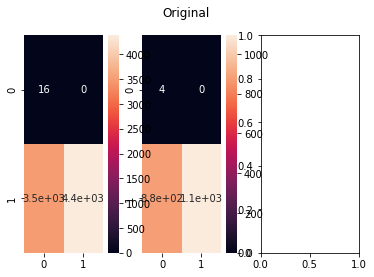

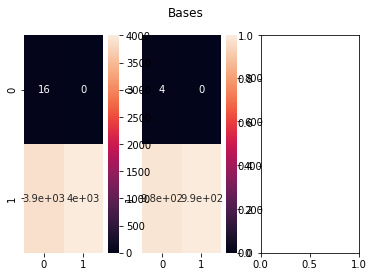

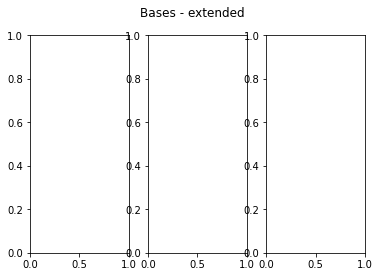

In [32]:

y_train_clipped = y_train.clip(min=0)
y_test_clipped = y_test.clip(min=0)

# Original
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Original")

y_train_pred =  org_clf.predict(X_train).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  org_clf.predict(X_test).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

# GD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Bases")

y_train_pred =  gd_clf.predict(X_train_bases).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  gd_clf.predict(X_test_bases).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

# GD Extended
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Bases - extended")
y_train_pred =  gd_ext_clf.predict_extended(X_train_bases).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  gd_ext_clf.predict_extended(X_test_bases).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

fig.show()

# Data Visualization

## Bases - density

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
pd.DataFrame(X_train_bases).plot.density(ax=axes[0])
pd.DataFrame(X_test_bases).plot.density(ax=axes[1])
plt.show()